<a href="https://colab.research.google.com/github/evbevz/epoxy-supervisor/blob/main/EpoxyLevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
try:
    import google.colab
    IS_COLAB_ENV = True
except:
    IS_COLAB_ENV = False
if IS_COLAB_ENV:
    %pip install ultralytics
    !git clone https://github.com/evbevz/epoxy-supervisor.git
    dirBase = '/content/drive/MyDrive/Colab Notebooks/'

    from google.colab import drive
    drive.mount('/content/drive/')
else:
    dirBase = '/home/nikolay/opencv/'
%cd "{dirBase}epoxy-supervisor/"

In [2]:
import epoxylib
import os
from ultralytics import YOLO
from ultralytics import settings

# Значение уверенности в правильности распознавания, ниже которого не будем считать, что точки определились правильно. Т.е. координаты такой точки будем считать ложными и точку игнорировать.
kptConfidence = 0.8 # Сейчас точки если и распознаются, то с уверенностью больше 0.9

# Калибровочный файл в котором хранятся уровни от 0 до 20мл. В виде координат X,Y центра эллипса поверхности эпоксидки на каждом уровне.
#filenameAnnotation = f"{dirBase}epoxy-supervisor/samples/EpoxyLevelCalibrate.annotations.oldbutonepoint.xml"
filenameAnnotation = f"{dirBase}epoxy-supervisor/samples/EpoxyLevelCalibrate.Rev.6.1.annotations.xml"

# Файл весов обученной для распознавания модели
#filenameAIModel = "es.onepoint.yolo11s-pose.20250514.best.pt"
#filenameAIModel = "es.onepoint.yolo12s-pose.20250524.best.pt"
#filenameAIModel = "es.onepoint.yolo12s-pose.20250524.last.pt"
list_models = 
fullfilenameAIModel = f"{dirBase}epoxy-supervisor/weights/{filenameAIModel}"

# Калибруем шприц
arrayEpoxyLevel = epoxylib.Calibrate(filenameAnnotation)

# Загружаем модель
model = YOLO(fullfilenameAIModel)

In [3]:
# Постороения списка уровней по изображениям в папке
#dirFrameset = "lvl-test/frames"
dirFrameset = "frameset-033"
dataPath = f"{dirBase}epoxy-supervisor/{dirFrameset}"
data = os.listdir(dataPath)
data.sort()
levels = []
index_with_none = []
level = 20
for i, file in enumerate(data):
    fullPath = f"{dataPath}/{file}"
    level = epoxylib.GetEpoxyLevel(model, arrayEpoxyLevel, fullPath , kptConfidence, level)
    levels.append(level)
    if level is not None:
        print (f"Файл: {file}. Уровень эпоксидки: {level:.2f}")
    else:
        index_with_none.append(i)
        print (f"Файл: {file}. УРОВЕНЬ ЭПОКСИДКИ: NONE !!!")

Файл: 03300001.png. Уровень эпоксидки: 10.61
Файл: 03300002.png. Уровень эпоксидки: 10.47
Файл: 03300003.png. Уровень эпоксидки: 10.50
Файл: 03300004.png. Уровень эпоксидки: 10.52
Файл: 03300005.png. Уровень эпоксидки: 10.61
Файл: 03300006.png. Уровень эпоксидки: 10.41
Файл: 03300007.png. Уровень эпоксидки: 10.44
Файл: 03300008.png. Уровень эпоксидки: 10.54
Файл: 03300009.png. Уровень эпоксидки: 10.43
Файл: 03300010.png. Уровень эпоксидки: 10.44
Файл: 03300011.png. Уровень эпоксидки: 10.34
Файл: 03300012.png. Уровень эпоксидки: 10.24
Файл: 03300013.png. Уровень эпоксидки: 10.30
Файл: 03300014.png. Уровень эпоксидки: 10.19
Файл: 03300015.png. Уровень эпоксидки: 10.21
Файл: 03300016.png. Уровень эпоксидки: 10.19
Файл: 03300017.png. Уровень эпоксидки: 10.19
Файл: 03300018.png. Уровень эпоксидки: 10.26
Файл: 03300019.png. Уровень эпоксидки: 10.16
Файл: 03300020.png. Уровень эпоксидки: 10.14
Файл: 03300021.png. Уровень эпоксидки: 9.88
Файл: 03300022.png. Уровень эпоксидки: 10.71
Файл: 03300

In [4]:
# Показать был ли нераспознанный уровень эпоксидки и установить его в 0, если был.
for i in index_with_none:
    print (f"Индекс: {i},\tФайл: {data[i]}. УРОВЕНЬ ЭПОКСИДКИ: NONE !!!")
    levels[i] = 0

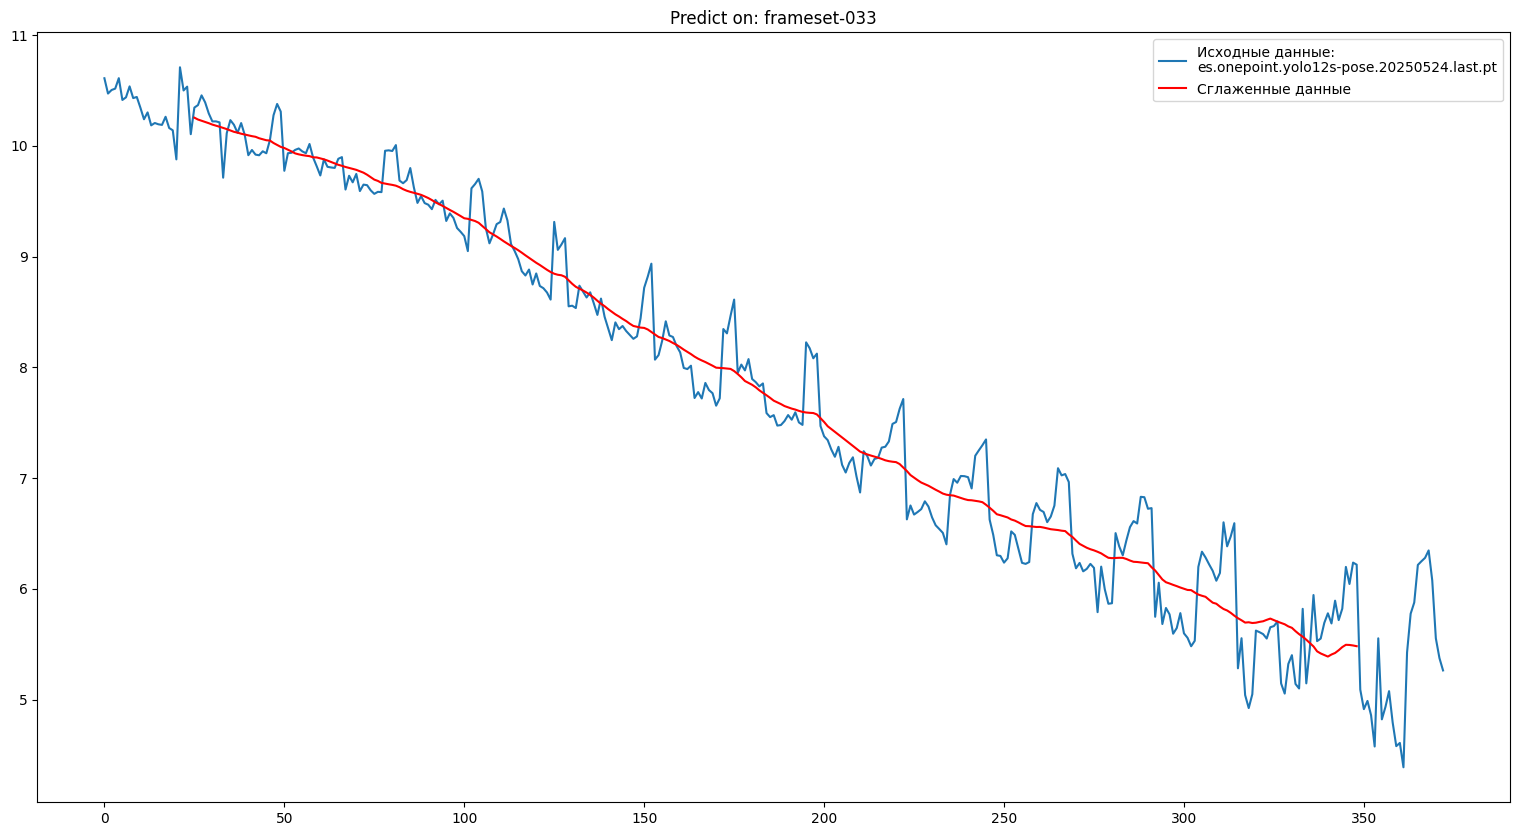

In [11]:
# https://www.delftstack.com/howto/python/smooth-data-in-python/
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd

# Применение фильтра Савицкого-Голея для сглаживания
#levels_savgol = savgol_filter(levels, 11, 3)
#levels_savgol = savgol_filter(levels, 50, 3)

# Метод скользящего среднего
# Простой и проверенный метод сглаживания — скользящее среднее. Он балансирует между скоростью вычислений и точностью границ данных.
# Использование функции np.cumsum для подсчёта скользящего среднего обеспечивает быстроту, но может приводить к краевым эффектам.
# Метод np.convolve с параметром mode='same' предотвращает изменение размера массива и позволяет сравнить сглаженные данные с исходными.
#levels_cumsum = np.cumsum(levels)
#levels_convolve = np.convolve(levels,1,mode='same')

#
levels_pd = pd.Series(levels).rolling(window=50, center=True).mean()

#from operator import sub
#delta = map(sub,levels,levels_pd)
#delta = np.array(levels) - np.array(levels_pd)

fig = plt.figure(figsize=(19, 10))
plt.plot(levels, label=f"Исходные данные:\n{filenameAIModel}")
plt.plot(levels_pd, color='red', label='Сглаженные данные')
#plt.plot(delta, color='green', label='Разница от среднего')
plt.title(f"Predict on: {dirFrameset}")
plt.legend()
#plt.show()
plt.savefig(f"{dirFrameset}.{filenameAIModel}.png")